In [62]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.preprocessing import LabelEncoder
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Input, concatenate, GRU
from keras.callbacks import TensorBoard 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,  precision_score, recall_score, f1_score
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.neighbors import KNeighborsClassifier
import datetime


In [63]:
corpus=[] #Crea lista corpus que contiene 
target=[] #Crea lista target que contiene 
edad=[] #Crea lista edad que contiene 
sexo=[] #Crea lista sexo que contiene 
severidad=[] #Crea lista severidad que contiene 

archivo=open("dataset_elpino.csv",encoding="utf-8")
header=archivo.readline().strip().split(";")
features=[] #Crea lista features que contiene 
for col in header: #recorre la cantidad de columnas en el csv
    col=col.split("-")[0].strip() 
    if col.startswith("Diag") or col.startswith("Proc"): #separa los diag de los proc.
        col=col.split(" ")
        col=col[0]+col[1]
    features.append(col) #Añade todas los headers de las columnas (diagnosticos, procedimientos)
for linea in archivo: 
    row=[] #crea una lista para almacenar la fila actual
    linea=linea.strip().split(";") #separa la lista por ;
    for i in range(len(linea)):
        col=linea[i].split("-")[0].strip()
        if i==67: # Si el índice "i" es 67 (columna 68).
            grd=col
            #target.append(grd[-1])
            target.append(grd) #almacena el grd de la fila actual
        elif i==66:
            sexo.append(1 if col=="Mujer" else 0) # almacena el sexo 1 si es mujer 0 si es hombre
        elif i==65:
            edad.append(int(col))#se alamacena la edad
        else:
            row.append(col) #se guardan el codigo de la columna correspondientes a la fila
    corpus.append(row)

In [64]:
df=pd.DataFrame(corpus,columns=features[:-3])  #crea una tabla de datos (un DataFrame) a partir de la información que le damos. ingresamos corpus (matris con los codigos de los diagnosticos ) y fetures (como queremos dividir las columnas)
df["GRD"]=target #Esto crea una nueva columna en el DataFrame df y la nombra "GRD".

In [65]:
dfsexo = pd.DataFrame({"Sexo": sexo, "GRD": target})

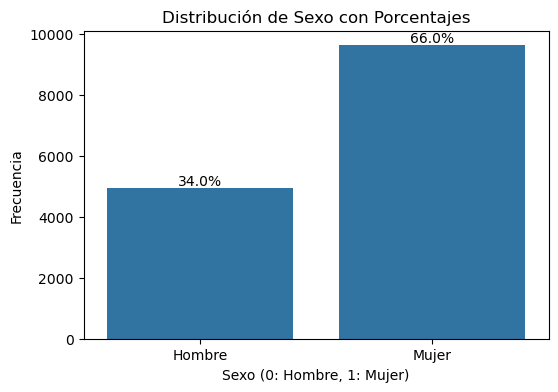

In [66]:

plt.figure(figsize=(6, 4))
ax = sns.countplot(x=sexo)
plt.title('Distribución de Sexo con Porcentajes')
plt.xlabel('Sexo (0: Hombre, 1: Mujer)')
plt.ylabel('Frecuencia')
plt.xticks([0, 1], ['Hombre', 'Mujer'])

total = len(sexo)
for p in ax.patches:
    porcentaje = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.text(x, y, porcentaje, ha='center', va='bottom')

plt.show()

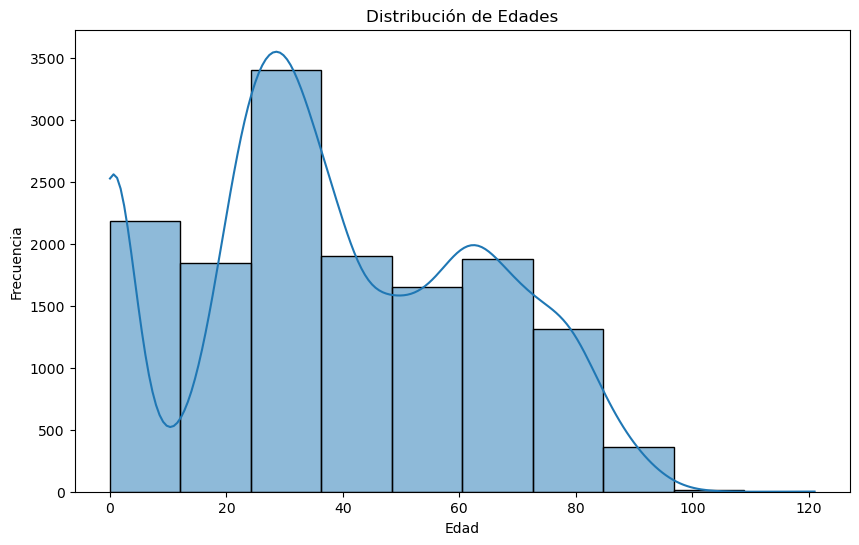

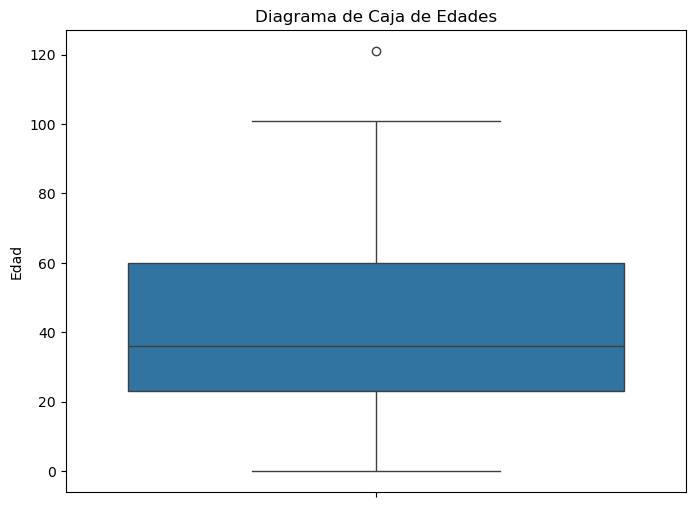

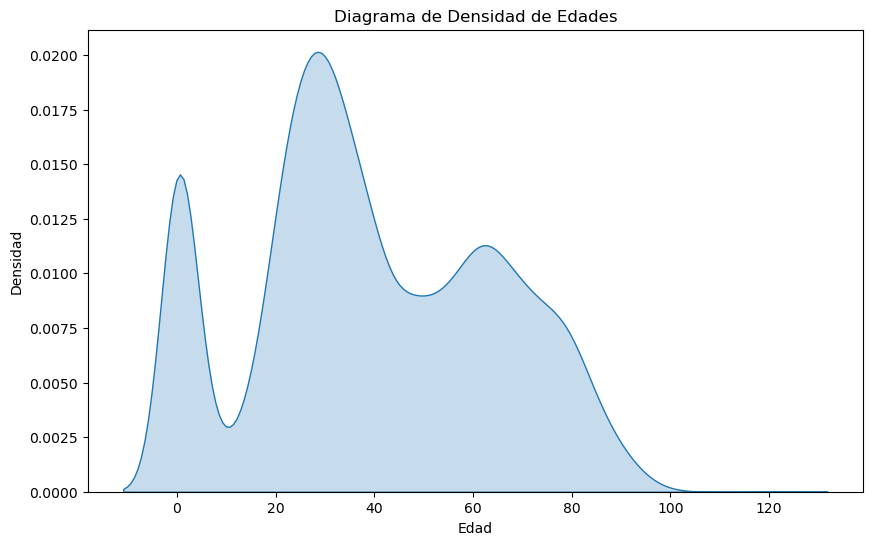

In [67]:
# Crear un histograma
plt.figure(figsize=(10, 6))
sns.histplot(edad, bins=10, kde=True)
plt.title('Distribución de Edades')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.show()

# Crear un diagrama de caja (boxplot)
plt.figure(figsize=(8, 6))
sns.boxplot(y=edad)
plt.title('Diagrama de Caja de Edades')
plt.ylabel('Edad')
plt.show()

# Crear un diagrama de densidad (KDE)
plt.figure(figsize=(10, 6))
sns.kdeplot(edad, fill=True)
plt.title('Diagrama de Densidad de Edades')
plt.xlabel('Edad')
plt.ylabel('Densidad')
plt.show()

In [68]:
df["GRD"].value_counts()[:10] #Esto selecciona la columna llamada "GRD" del DataFrame df y cuenta cuántas veces aparece cada valor único en la columna "GRD". [:20] Esto es un "slice", Toma los primeros 20 elementos de la Serie resultante.


GRD
146101    813
146121    639
146131    538
158171    389
134161    325
071141    317
044153    287
061131    252
041023    248
146102    244
Name: count, dtype: int64

In [73]:
features_procedimientos=[] #crea una lista de procediminetos
features_diagnosticos=[] #crea una lista de diagnosticos
for j in range(1,36):  #recorre las columnas relacionadas al diagnostico del grd
    field="Diag"+str(j).zfill(2) #rellena el texto con el numero de la columna, ---.zfill(2) rellena la cadena de texto con ceros a la izquierda hasta que tenga una longitud de 2 caracteres. Por ejemplo, si j es 1, str(j) será "1", y .zfill(2) lo convertirá en "01". Si j es 10, str(j) será "10", y .zfill(2) lo dejará como "10".
    features_diagnosticos.append(field) #Esto agrega el valor de field a la lista features_diagnosticos.
for j in range(1,31): #recorre las columnas relacionadas al procedimiento del grd
    field="Proced"+str(j).zfill(2)#.rellena el texto con el numero de la columna
    features_procedimientos.append(field)#Esto agrega el valor de field a la lista features_procedimientos.


In [ ]:
procedimientos={}#Esto crea un diccionario vacío llamado procedimientos. Este diccionario se utilizará para contar la frecuencia de cada código de procedimiento.
diagnosticos={}#Esto crea un diccionario vacío llamado diagnosticos. Este diccionario se utilizará para contar la frecuencia de cada código de diagnosticos.
for i, row in df.iterrows():#Esto inicia un bucle for que itera sobre cada fila del  data
    for j in range(1,36): #recorre las columas dianostico
        field="Diag"+str(j).zfill(2) #rellena el texto con el numero de la columna
        if row[field] not in diagnosticos:#esto verifica si el valor de la celda actual (el código de diagnóstico) ya existe como clave en el diccionario diagnosticos.
            diagnosticos[row[field]]=1 #Si el código de diagnóstico no existe en el diccionario, se agrega como clave con un valor de 1
        else:
            diagnosticos[row[field]]+=1#suma uno al contador de diagnosticos
    for j in range(1,31):#recorre las columas procedimientos
        field="Proced"+str(j).zfill(2) #rellena el texto con el numero de la columna
        if row[field] not in procedimientos:#esto verifica si el valor de la celda actual (el código de procedimientos) ya existe como clave en el diccionario procedimientos.
            procedimientos[row[field]]=1#Si el código de procedimientos no existe en el diccionario, se agrega como clave con un valor de 1
        else:
            procedimientos[row[field]]+=1#suma uno al contador de procedimientos
token_diagnosticos=list(diagnosticos.keys())#Esto crea una lista llamada token_diagnosticos que contiene todos los códigos de diagnóstico únicos encontrados en el DataFrame.
token_procedimientos=list(procedimientos.keys())#Esto crea una lista llamada token_procedimientos que contiene todos los códigos de procedimientos únicos encontrados en el DataFrame.
vocabulario=len(token_diagnosticos)+len(token_procedimientos)+1#Esto calcula el tamaño del vocabulario total, que es la suma del número de diagnósticos únicos, el número de procedimientos únicos
print("Diagnósticos: ",len(token_diagnosticos))
print("Procedimientos: ",len(token_procedimientos))
print("Vocabulario: ",vocabulario)

Diagnósticos:  1420
Procedimientos:  392
Vocabulario:  1813


In [ ]:
token_rows=[]#Esto crea una lista vacía llamada token_rows
for i, row in df.iterrows():
    token_row=[]#Crea una lista vacía llamada token_row para almacenar los tokens numéricos de la fila actual.
    for j in range(1,36):#bucle entre las columnas de diagnostico
        field="Diag"+str(j).zfill(2)#rellena el texto con el numero de la columna
        token_row.append(1+token_diagnosticos.index(row[field])) #obtiene el código de diagnóstico de la celda actual, encuentra el índice del código de diagnóstico en la lista token_diagnosticos, suma 1 al índice encontrado. Esto asegura que los tokens de diagnóstico comiencen desde 1 en lugar de 0.agrega el token numérico a la lista token_row
    for j in range(1,31):#bucle entre las columnas de procedimientos
        field="Proced"+str(j).zfill(2)#rellena el texto con el numero de la columna
        token_row.append(1+len(token_diagnosticos)+token_procedimientos.index(row[field]))#obtiene el código de procedimientos de la celda actual, encuentra el índice del código de procedimientos en la lista token_diagnosticos,suma 1 y 377 al índice encontrado. El número 377 parece ser el total de codigos de diagnosticos unicos encontrados anteriormente. Esto se hace para que los tokens de procedimiento tengan valores distintos a los tokens de diagnóstico.
    token_rows.append(token_row)#Después de procesar todas las columnas de diagnóstico y procedimiento de una fila, esto agrega la lista token_row

len(token_diagnosticos) 

1420

Codigo 1 Red Neuronal

In [ ]:

# Asumiendo que 'data' es tu DataFrame filtrado y 'token_rows' es tu lista de tokens numéricos

# Crear secuencias con diagnósticos y procedimientos
secuencias_tokens = [row[:65] for row in token_rows]  # Tomar los primeros 65 tokens (diagnósticos y procedimientos)

# Rellenar las secuencias para que tengan la misma longitud
max_longitud = max(len(seq) for seq in secuencias_tokens)
secuencias_padded = pad_sequences(secuencias_tokens, maxlen=max_longitud)

# Codificar la variable objetivo 'GRD' a numérico
le_grd = LabelEncoder()
target_encoded = le_grd.fit_transform(df['GRD'])
num_classes = len(np.unique(target_encoded))  # Asegurar el número correcto de clases


# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(secuencias_padded, target_encoded, test_size=0.2, random_state=42)
vocabulario_size = len(set(token for row in secuencias_tokens for token in row)) + 1  # +1 para el relleno

vocabulario_size

1813

In [ ]:
num_grd_unicos = df['GRD'].nunique()
print(f"El número de valores únicos en la columna 'GRD' es: {num_grd_unicos}")

In [ ]:

# Definir el modelo con una capa GRU
model = Sequential()
model.add(Embedding(vocabulario_size, 100, input_length=max_longitud))
model.add(GRU(128)) # Añade una capa GRU con 128 unidades
model.add(Dense(256, activation='relu'))
model.add(Dense(num_grd_unicos, activation='softmax')) # 10 neuronas para las 10 clases

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) # Usar sparse_categorical_crossentropy

# Configuración de TensorBoard
log_dir = "logs/fit/diagproc_gru/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Entrenar el modelo con TensorBoard
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[tensorboard_callback])

# Evaluar el modelo
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss (GRU): {loss}, Accuracy (GRU): {accuracy}')

# Imprimir información adicional
print("Valores únicos en y_train:", np.unique(y_train))
print("Valores únicos en y_test:", np.unique(y_test))

Epoch 1/10
81/81 [==============================] - 5s 50ms/step - loss: 2.0430 - accuracy: 0.2527 - val_loss: 1.8342 - val_accuracy: 0.3251
Epoch 2/10
81/81 [==============================] - 3s 42ms/step - loss: 1.2012 - accuracy: 0.5455 - val_loss: 0.7597 - val_accuracy: 0.7257
Epoch 3/10
81/81 [==============================] - 3s 38ms/step - loss: 0.5676 - accuracy: 0.7766 - val_loss: 0.4486 - val_accuracy: 0.8243
Epoch 4/10
81/81 [==============================] - 3s 35ms/step - loss: 0.4128 - accuracy: 0.8403 - val_loss: 0.3845 - val_accuracy: 0.8737
Epoch 5/10
81/81 [==============================] - 2s 28ms/step - loss: 0.3186 - accuracy: 0.8904 - val_loss: 0.4056 - val_accuracy: 0.8752
Epoch 6/10
81/81 [==============================] - 3s 33ms/step - loss: 0.2443 - accuracy: 0.9132 - val_loss: 0.2807 - val_accuracy: 0.8983
Epoch 7/10
81/81 [==============================] - 3s 33ms/step - loss: 0.1902 - accuracy: 0.9394 - val_loss: 0.2915 - val_accuracy: 0.8921
Epoch 8/10
81

26/26 [==============================] - 0s 3ms/step


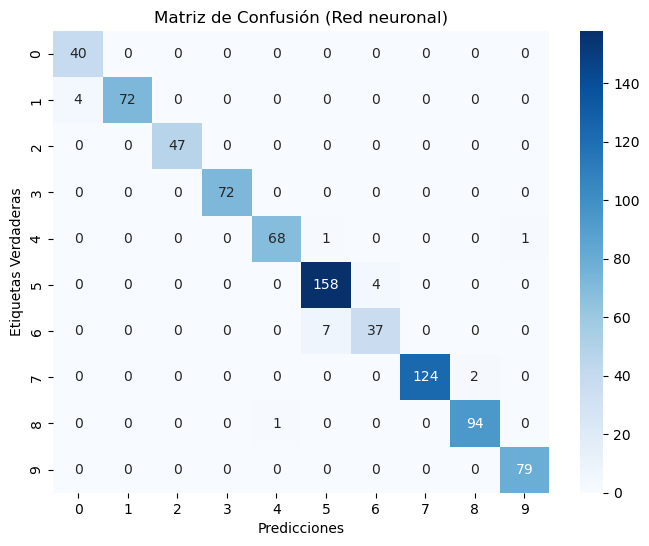

Número total de pruebas realizadas: 811
Número total de filas analizadas: 4052


In [ ]:
# Obtener las predicciones del modelo
y_pred = np.argmax(model.predict(X_test), axis=-1)

# Calcular la matriz de confusión usando y_test y y_pred
cm = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas Verdaderas')
plt.title('Matriz de Confusión (Red neuronal)')
plt.show()

# Imprimir el número total de pruebas realizadas
total_pruebas = np.sum(cm)
print(f"Número total de pruebas realizadas: {total_pruebas}")

#imprimir el numero total de filas analizadas, si la variable data existe.
try:
  print(f"Número total de filas analizadas: {len(df)}")
except NameError:
  print("La variable 'data' no está definida.")

Matriz de Confusión Binaria para la Clase 0:


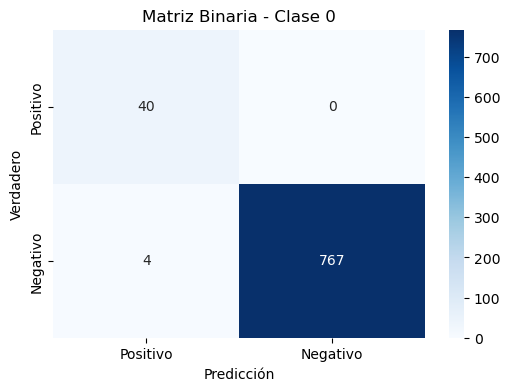

Métricas para la Clase 0:
  Precisión: 0.9091
  Recall: 1.0000
  F1-score: 0.9524
------------------------------
Matriz de Confusión Binaria para la Clase 1:


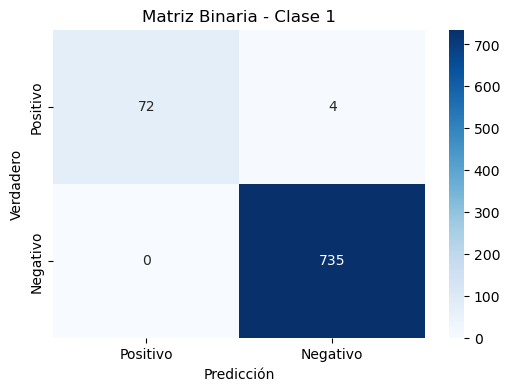

Métricas para la Clase 1:
  Precisión: 1.0000
  Recall: 0.9474
  F1-score: 0.9730
------------------------------
Matriz de Confusión Binaria para la Clase 2:


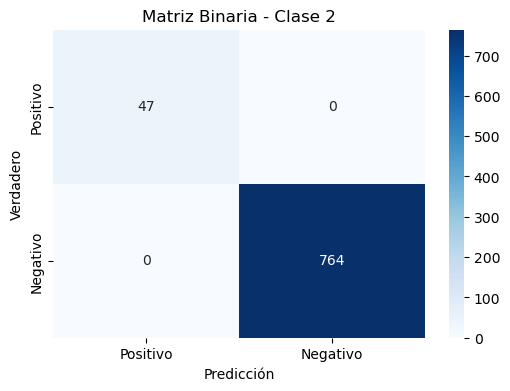

Métricas para la Clase 2:
  Precisión: 1.0000
  Recall: 1.0000
  F1-score: 1.0000
------------------------------
Matriz de Confusión Binaria para la Clase 3:


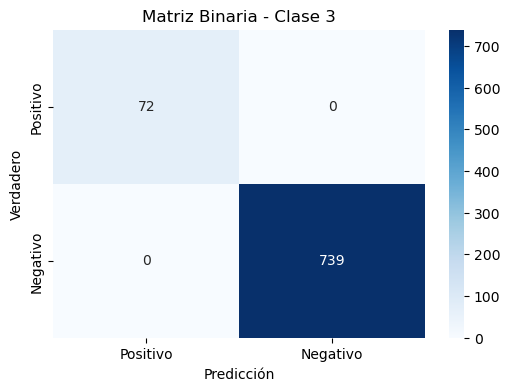

Métricas para la Clase 3:
  Precisión: 1.0000
  Recall: 1.0000
  F1-score: 1.0000
------------------------------
Matriz de Confusión Binaria para la Clase 4:


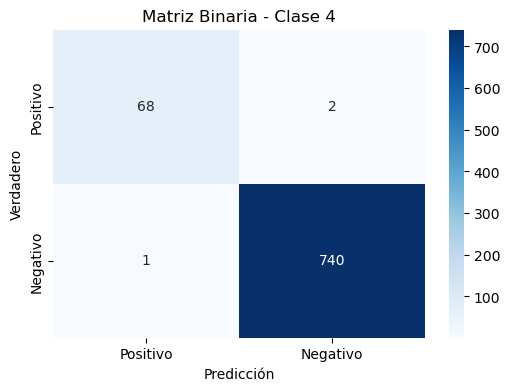

Métricas para la Clase 4:
  Precisión: 0.9855
  Recall: 0.9714
  F1-score: 0.9784
------------------------------
Matriz de Confusión Binaria para la Clase 5:


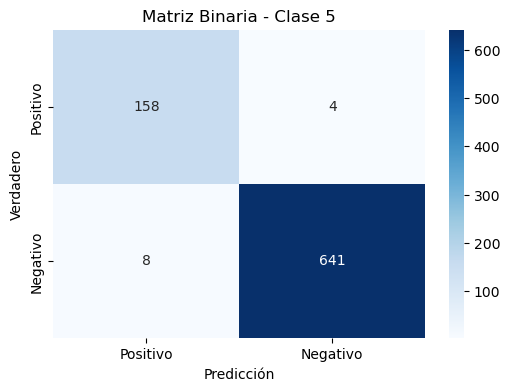

Métricas para la Clase 5:
  Precisión: 0.9518
  Recall: 0.9753
  F1-score: 0.9634
------------------------------
Matriz de Confusión Binaria para la Clase 6:


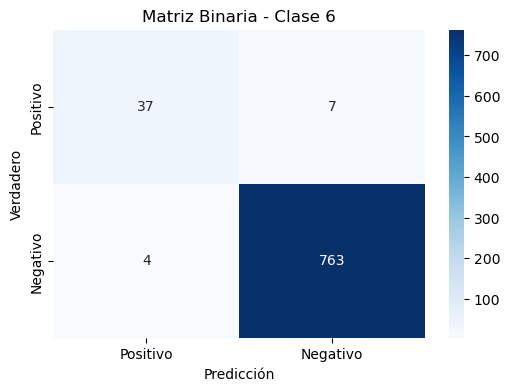

Métricas para la Clase 6:
  Precisión: 0.9024
  Recall: 0.8409
  F1-score: 0.8706
------------------------------
Matriz de Confusión Binaria para la Clase 7:


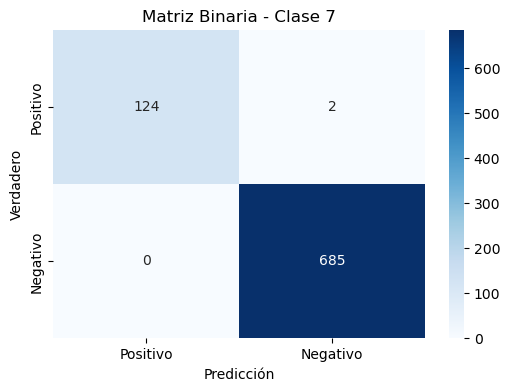

Métricas para la Clase 7:
  Precisión: 1.0000
  Recall: 0.9841
  F1-score: 0.9920
------------------------------
Matriz de Confusión Binaria para la Clase 8:


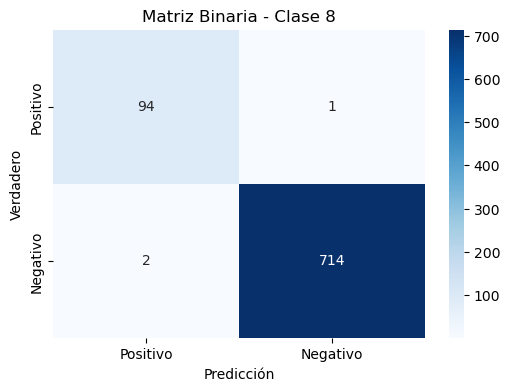

Métricas para la Clase 8:
  Precisión: 0.9792
  Recall: 0.9895
  F1-score: 0.9843
------------------------------
Matriz de Confusión Binaria para la Clase 9:


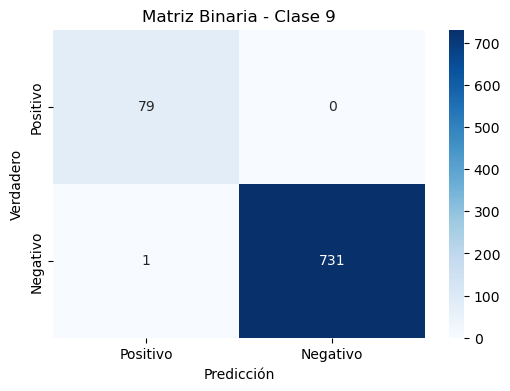

Métricas para la Clase 9:
  Precisión: 0.9875
  Recall: 1.0000
  F1-score: 0.9937
------------------------------


In [80]:
num_clases = cm.shape[0]

for i in range(num_clases):
    # Crear matriz binaria para la clase i
    cm_binario = np.zeros((2, 2), dtype=int)
    cm_binario[0, 0] = cm[i, i]  # Verdaderos Positivos
    cm_binario[0, 1] = np.sum(cm[i, :]) - cm[i, i]  # Falsos Negativos
    cm_binario[1, 0] = np.sum(cm[:, i]) - cm[i, i]  # Falsos Positivos
    cm_binario[1, 1] = np.sum(cm) - cm[i, :].sum() - cm[:, i].sum() + cm[i, i] # Verdaderos Negativos

    print(f"Matriz de Confusión Binaria para la Clase {i}:")

    # Visualizar la matriz de confusión binaria
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_binario, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Positivo', 'Negativo'],
                yticklabels=['Positivo', 'Negativo'])
    plt.xlabel('Predicción')
    plt.ylabel('Verdadero')
    plt.title(f'Matriz Binaria - Clase {i}')
    plt.show()

    # Calcular precisión, recall y F1-score para la clase i
    tp = cm_binario[0, 0]
    fp = cm_binario[1, 0]
    fn = cm_binario[0, 1]

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"Métricas para la Clase {i}:")
    print(f"  Precisión: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-score: {f1:.4f}")
    print("-" * 30)